## GPUs
As our models get more complicated we'll need more complicated compute.
<img src="https://www.nvidia.com/content/dam/en-zz/Solutions/data-center/hopper-architecture/hpc-h200-bb460_420-d.jpg">

## In torch each tensor has a 'device' which is normally either 'cpu' or 'gpu' 

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import seaborn as sns


In [2]:
%%timeit

size=(1000,1000)
x=torch.randn(size).cuda()

for i in range(200):
    y=torch.matmul(x,x)

189 ms ± 55.3 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [3]:
%%timeit

size=(1000,1000)
x=torch.randn(size).cpu()

for i in range(200):
    y=torch.matmul(x,x)

3.67 s ± 66 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Device agnositc code
The code above can be a pain, if you switch between computers with and without GPUs, but we can make it run on anything with the following lines.



In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [5]:
%%timeit
size=(1000,1000)
x=torch.randn(size).to(device)

for i in range(200):
    y=torch.matmul(x,x)

187 ms ± 14.7 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### The primary cause of failure in a gpu is lack of memory
GPUs have between a few to 100+ GB of video ram which hold your model's weights and activations (and all tensors)


In [6]:
#test_layer=torch.nn.Linear(100000,100000,device='cuda')


# Convolutional Neural Networks (CNNs)
Convolutional Neural Networks (CNNs) are a class of deep learning models specifically designed for processing structured grid-like data, such as images, we'll go through some image data, and you'll write your own training loop. 

## Image data

A reminder that we always want to use 3 splits for 'real' projects, to make this demo a bit easier we will use only 2 train and test.

In [7]:
# Download and create datasets
data = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=None)

100%|██████████| 26421880/26421880 [00:02<00:00, 10812326.73it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 187556.64it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3160104.11it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 69877919.07it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



0


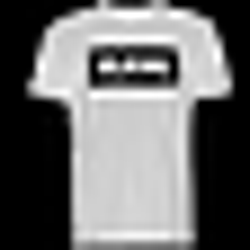

In [8]:
img,label=data[1]
print(label)
display(img.resize((250,250)))

In [9]:
# This is useful for making plots it takes an integer
lookup_dict={
    0 :'T-shirt/top',
    1 :'Trouser',
    2 :'Pullover',
    3 :'Dress',
    4 :'Coat',
    5 :'Sandal',
    6 :'Shirt',
    7 :'Sneaker',
    8 :'Bag',
    9 :'Ankle boot'}
print(lookup_dict[label])

T-shirt/top


In [10]:
print(np.asarray(img).shape)

(28, 28)


In [11]:

display(np.asarray(img))


array([[  0,   0,   0,   0,   0,   1,   0,   0,   0,   0,  41, 188, 103,
         54,  48,  43,  87, 168, 133,  16,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   1,   0,   0,   0,  49, 136, 219, 216, 228, 236,
        255, 255, 255, 255, 217, 215, 254, 231, 160,  45,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,  14, 176, 222, 224, 212, 203, 198, 196,
        200, 215, 204, 202, 201, 201, 201, 209, 218, 224, 164,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0, 188, 219, 200, 198, 202, 198, 199, 199,
        201, 196, 198, 198, 200, 200, 200, 200, 201, 200, 225,  41,   0,
          0,   0],
       [  0,   0,   0,   0,  51, 219, 199, 203, 203, 212, 238, 248, 250,
        245, 249, 246, 247, 252, 248, 235, 207, 203, 203, 222, 140,   0,
          0,   0],
       [  0,   0,   0,   0, 116, 226, 206, 204, 207, 204, 101,  75,  47,
         73,  48,  50,  45,  51,  63, 113, 222, 202, 206, 220, 224,   0,
          0,   0],
       [  

# Data Prep

1. Normalize
2. Convert to Tensor

    *switch 1 and 2*

In [12]:
batch_size=64
transform = transforms.Compose([
        transforms.ToTensor(), # Converts to tensor and 0->1
        transforms.Normalize((0.5,), (0.5)) # Returns (x-mean)/(std), (0-1) -> (-1-1)
])

train_data = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                                   download=True, transform=transform)
test_data  = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                                   download=True, transform=transform)
# Create DataLoaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader  = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [14]:
img,label=test_data[0]
print(img.shape)
print(img,label)

torch.Size([1, 28, 28])
tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.00

In [15]:
# Create DataLoaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader  = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [16]:
# Quick CNN adapted for 1-channel Fashion-MNIST (28x28 images).
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, stride=1, padding=1)
        
        self.pool  = nn.MaxPool2d(2, 2)
        # After two 2x2 pools on 28x28, spatial size is 7x7
        self.fc1   = nn.Linear(32 * 7 * 7, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1) # Flatten
        return self.fc1(x)



model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
lr=1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)

        



# Exercise

You've written models in lab 1, data handling in lab 2, and for this lab let's write our own training loop

## Steps
* You'll need a loop over the number of epochs
* You'll need to loop over batches from your train data loader
* You'll need to make a prediction, and use that prediction to calculate a loss
* you'll calculate the gradients and step the optimizers
* You'll need to calculate the validation loss for each epoch
* Train!

In [18]:
# Training loop
num_epochs = 10
loss_plot_train = []
loss_plot_test = []

for epoch in range(num_epochs):
    # Training:
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        
    avg_loss = running_loss / len(train_loader.dataset)
    loss_plot_train.append(avg_loss)

    # Validation: 
    model.eval()
    running_loss_test = 0.0
    with torch.no_grad():
        prediction, truth = zip(*[(model(x.to(device)), y.to(device)) for x,y in test_loader])
        prediction = torch.cat(prediction, dim=0)
        truth = torch.cat(truth, dim=0)
        val_loss = criterion(prediction, truth)
        loss_plot_test.append(val_loss.item())
    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {avg_loss:.4f}, Val Loss: {val_loss:.4f}")

Epoch [1/10] - Loss: 0.4708, Val Loss: 0.3687
Epoch [2/10] - Loss: 0.3106, Val Loss: 0.3073
Epoch [3/10] - Loss: 0.2704, Val Loss: 0.2867
Epoch [4/10] - Loss: 0.2465, Val Loss: 0.2808
Epoch [5/10] - Loss: 0.2301, Val Loss: 0.2720
Epoch [6/10] - Loss: 0.2142, Val Loss: 0.2698
Epoch [7/10] - Loss: 0.2035, Val Loss: 0.2475
Epoch [8/10] - Loss: 0.1927, Val Loss: 0.2685
Epoch [9/10] - Loss: 0.1844, Val Loss: 0.2441
Epoch [10/10] - Loss: 0.1758, Val Loss: 0.2511


# Plot your losses by epoch here

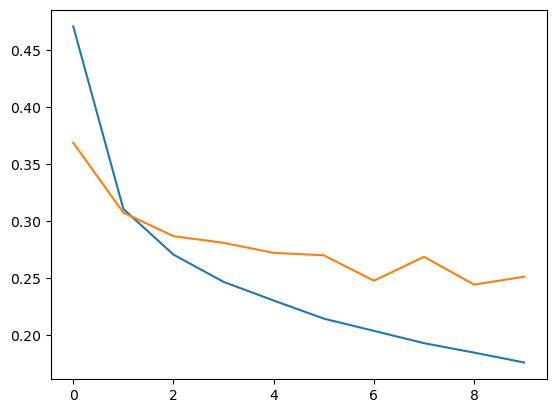

In [20]:
"""Your Loss Plot"""
import matplotlib.pyplot as plt

plt.plot(loss_plot_train, label='Train')
plt.plot(loss_plot_test, label='Test')
plt.show()

# Let's do some investigation
1. Make your trained model is named **model**
2. Let's plot a confusion matrix
3. Let's look at some of the worst examples

In [21]:
with torch.no_grad():
    model.eval()
    prediction,truth,imgs=zip(*[(torch.softmax(model(x.to(device)),axis=1),y,x) for x,y in test_loader])

prediction=torch.cat(prediction,dim=0).cpu().numpy()
truth=torch.cat(truth,dim=0).cpu().numpy()
imgs=torch.cat(imgs,dim=0).cpu().numpy()
predicted_labels=np.argmax(prediction,axis=1)

In [22]:
(predicted_labels==truth).mean()

0.914

<Axes: >

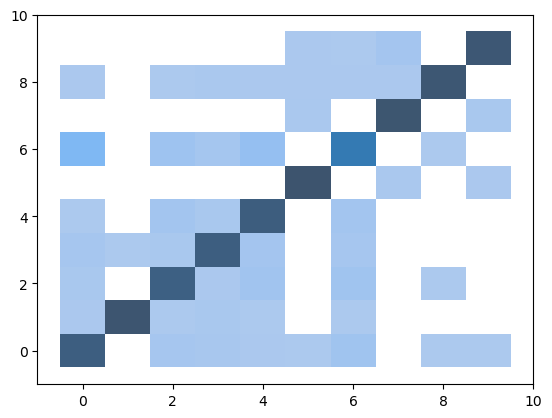

In [23]:
sns.histplot(x=predicted_labels,y=truth,discrete=True,bins=20)

----------------- 5316 -----------------
Predicted Probability 1.00 Class 9 Ankle boot
True Class 7 Sneaker
(1, 28, 28)


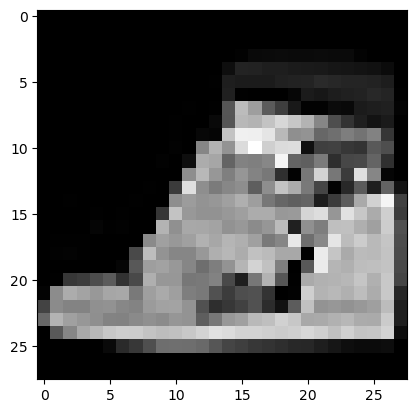

----------------- 4693 -----------------
Predicted Probability 1.00 Class 9 Ankle boot
True Class 7 Sneaker
(1, 28, 28)


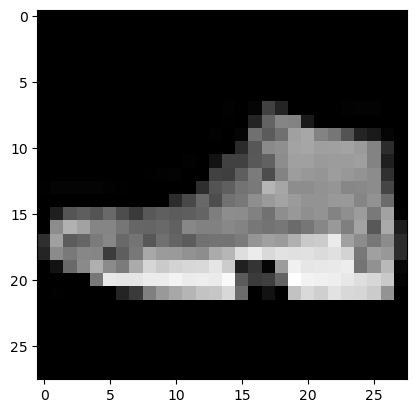

----------------- 2914 -----------------
Predicted Probability 1.00 Class 9 Ankle boot
True Class 7 Sneaker
(1, 28, 28)


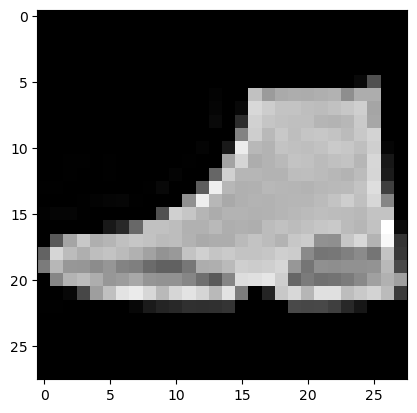

----------------- 1111 -----------------
Predicted Probability 1.00 Class 3 Dress
True Class 0 T-shirt/top
(1, 28, 28)


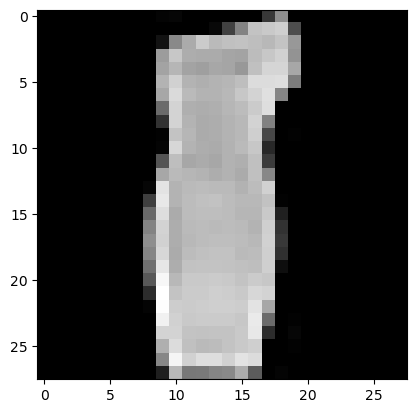

----------------- 3531 -----------------
Predicted Probability 1.00 Class 3 Dress
True Class 0 T-shirt/top
(1, 28, 28)


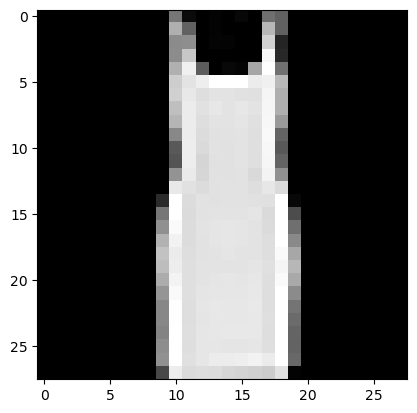

----------------- 787 -----------------
Predicted Probability 1.00 Class 3 Dress
True Class 1 Trouser
(1, 28, 28)


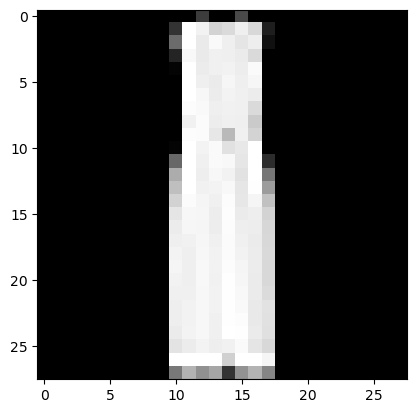

----------------- 5806 -----------------
Predicted Probability 1.00 Class 0 T-shirt/top
True Class 6 Shirt
(1, 28, 28)


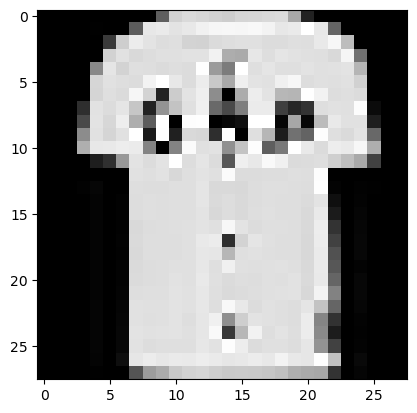

----------------- 3489 -----------------
Predicted Probability 1.00 Class 3 Dress
True Class 2 Pullover
(1, 28, 28)


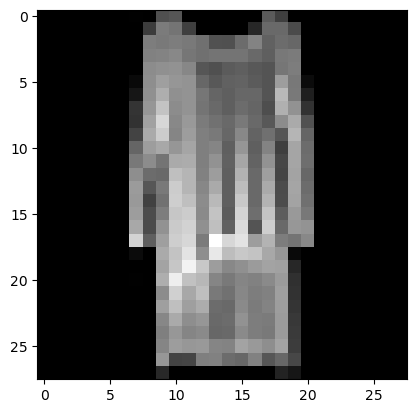

----------------- 4609 -----------------
Predicted Probability 1.00 Class 5 Sandal
True Class 8 Bag
(1, 28, 28)


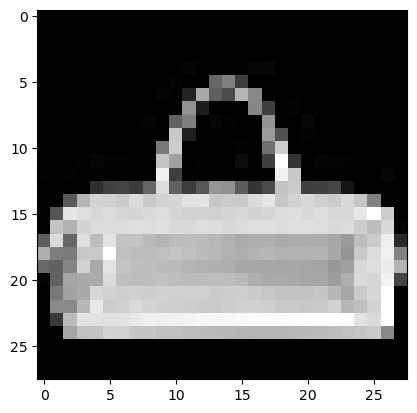

----------------- 3188 -----------------
Predicted Probability 1.00 Class 2 Pullover
True Class 6 Shirt
(1, 28, 28)


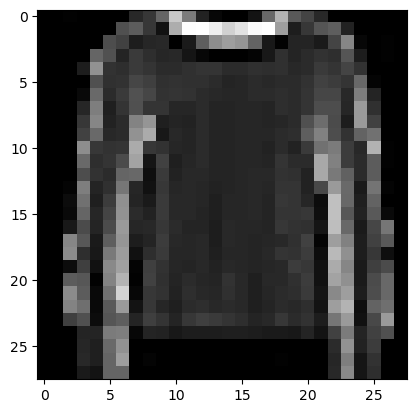

In [24]:
import matplotlib.pyplot as plt
wrong= (predicted_labels != truth)
sorted_prediction=np.flip(np.argsort(prediction.max(axis=1)))

worst_predictions= [i for i in sorted_prediction if wrong[i]]

for index in worst_predictions[0:10]:
    
    print("-----------------",index,"-----------------")
    print(f"Predicted Probability {prediction[index].max().item():.2f}", 'Class' ,predicted_labels[index], lookup_dict[predicted_labels[index]])
    print("True Class",truth[index], lookup_dict[truth[index]])
    _plot_img=imgs[index]
    print(_plot_img.shape)
    plt.imshow(_plot_img[0],cmap='gray')
    plt.show()
    


# DIY - CIFAR10

Below is some code to grab a color dataset, I would like you to train and evaluate your own CNN model 

## 410 - Goal is a model that is at least 60% accurate on test set
This should be doable with the few modification needed to get the simple model above to run

## 510 - Goal is a model that is at least 75% accurate on test set
Note: You may need to look at some existing models like VGG16 for this level of performance, but shouldn't need to use data augmentation.

100%|██████████| 170498071/170498071 [00:05<00:00, 32756204.22it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


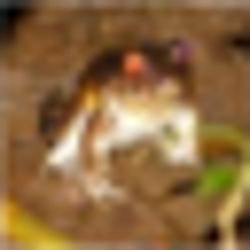

In [25]:
data = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True)
img,label=data[0]
display(img.resize((250,250)))

In [26]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 64

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

cifar_lookup_dict={
    0 :'Plane',
    1 :'Car',
    2 :'Bird',
    3 :'Cat',
    4 :'Deer',
    5 :'Dog',
    6 :'Frog',
    7 :'Horse',
    8 :'Ship',
    9 :'Truck'}


Files already downloaded and verified


/packages/miniconda-t2/20230523/envs/jupyter-cuda121-20230610/lib/python3.8/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Files already downloaded and verified


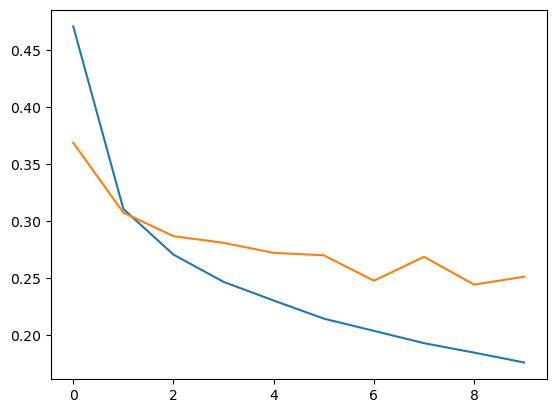

In [28]:
plt.plot(loss_plot_train)
plt.plot(loss_plot_test)
plt.show()

In [29]:
print(trainset[0][0].shape)
trainset[0]

torch.Size([3, 32, 32])


(tensor([[[-0.5373, -0.6627, -0.6078,  ...,  0.2392,  0.1922,  0.1608],
          [-0.8745, -1.0000, -0.8588,  ..., -0.0353, -0.0667, -0.0431],
          [-0.8039, -0.8745, -0.6157,  ..., -0.0745, -0.0588, -0.1451],
          ...,
          [ 0.6314,  0.5765,  0.5529,  ...,  0.2549, -0.5608, -0.5843],
          [ 0.4118,  0.3569,  0.4588,  ...,  0.4431, -0.2392, -0.3490],
          [ 0.3882,  0.3176,  0.4039,  ...,  0.6941,  0.1843, -0.0353]],
 
         [[-0.5137, -0.6392, -0.6235,  ...,  0.0353, -0.0196, -0.0275],
          [-0.8431, -1.0000, -0.9373,  ..., -0.3098, -0.3490, -0.3176],
          [-0.8118, -0.9451, -0.7882,  ..., -0.3412, -0.3412, -0.4275],
          ...,
          [ 0.3333,  0.2000,  0.2627,  ...,  0.0431, -0.7569, -0.7333],
          [ 0.0902, -0.0353,  0.1294,  ...,  0.1608, -0.5137, -0.5843],
          [ 0.1294,  0.0118,  0.1137,  ...,  0.4431, -0.0745, -0.2784]],
 
         [[-0.5059, -0.6471, -0.6627,  ..., -0.1529, -0.2000, -0.1922],
          [-0.8431, -1.0000,

In [38]:
# Quick CNN adapted for 1-channel Fashion-MNIST (28x28 images).
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        size=128
        super(SimpleCNN, self).__init__()
        self.conv1_1 = nn.Conv2d(3, size, 3, stride=1, padding=1)
        self.conv1_2 = nn.Conv2d(size, size, 3, stride=1, padding=1)
        self.conv1_3 = nn.Conv2d(size, size, 3, stride=1, padding=1)

        self.conv2_1 = nn.Conv2d(size, size*2, 3, stride=1, padding=1)
        self.conv2_2 = nn.Conv2d(size*2, size*2, 3, stride=1, padding=1)
        self.conv2_3 = nn.Conv2d(size*2, size*2, 3, stride=1, padding=1)
        
        self.conv3 = nn.Conv2d(size*2, size*4, 3, stride=1, padding=1)
        
        self.pool  = nn.MaxPool2d(2, 2)
        # After two 2x2 pools on 28x28, spatial size is 7x7
        self.fc1   = nn.Linear(size*4 * 4 * 4 , size)
        self.fc2   = nn.Linear(size, size)
        self.fc3   = nn.Linear(size , num_classes)

    def forward(self, x):
        x = F.relu(self.conv1_1(x))
        x = F.relu(self.conv1_2(x))
        x = F.relu(self.conv1_3(x))

        x = self.pool(x)
        x = F.relu(self.conv2_1(x))
        x = F.relu(self.conv2_2(x))
        x = F.relu(self.conv2_3(x))

        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)

        x = x.view(x.size(0), -1) # Flatten

        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        x=self.fc3(x)

        return x



cifar10_model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
lr=1e-3
optimizer = optim.Adam( cifar10_model.parameters(),lr=lr,weight_decay=1e-4)


In [39]:
from tqdm import tqdm

In [40]:
epochs=10

_loss_plot_train=[]
_loss_plot_test=[]

for epoch in range(epochs):
    cifar10_model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs =  cifar10_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    avg_loss = running_loss / len(train_loader.dataset)
    _loss_plot_train.append(avg_loss)
    
    with torch.no_grad():
        prediction,truth=zip(*[(cifar10_model(x.to(device)),y.to(device)) for x,y in test_loader])
        prediction=torch.cat(prediction,dim=0)
        truth=torch.cat(truth,dim=0)
        val_loss=criterion(prediction, truth)
        _loss_plot_test.append(val_loss.item())
    
    print(f"Epoch [{epoch+1}/{epochs}] - Loss: {avg_loss:.4f} Val Loss: {val_loss:.4f}")

  0%|          | 0/782 [00:00<?, ?it/s]/packages/miniconda-t2/20230523/envs/jupyter-cuda121-20230610/lib/python3.8/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 782/782 [00:32<00:00, 23.88it/s]


Epoch [1/10] - Loss: 1.9824 Val Loss: 1.6276


100%|██████████| 782/782 [00:32<00:00, 23.97it/s]


Epoch [2/10] - Loss: 1.4429 Val Loss: 1.3066


100%|██████████| 782/782 [00:32<00:00, 23.95it/s]


Epoch [3/10] - Loss: 1.1820 Val Loss: 1.0905


100%|██████████| 782/782 [00:32<00:00, 23.95it/s]


Epoch [4/10] - Loss: 1.0052 Val Loss: 0.9704


100%|██████████| 782/782 [00:32<00:00, 23.94it/s]


Epoch [5/10] - Loss: 0.8788 Val Loss: 0.8883


100%|██████████| 782/782 [00:32<00:00, 24.04it/s]


Epoch [6/10] - Loss: 0.7775 Val Loss: 0.8655


100%|██████████| 782/782 [00:32<00:00, 24.04it/s]


Epoch [7/10] - Loss: 0.7043 Val Loss: 0.7927


100%|██████████| 782/782 [00:32<00:00, 24.11it/s]


Epoch [8/10] - Loss: 0.6392 Val Loss: 0.7668


100%|██████████| 782/782 [00:32<00:00, 24.19it/s]


Epoch [9/10] - Loss: 0.5902 Val Loss: 0.7656


100%|██████████| 782/782 [00:32<00:00, 24.20it/s]


Epoch [10/10] - Loss: 0.5433 Val Loss: 0.7908


In [41]:
with torch.no_grad():
    cifar10_model.eval()
    prediction,truth,imgs=zip(*[(torch.softmax(cifar10_model(x.to(device)),axis=1),y,x) for x,y in test_loader])

prediction=torch.cat(prediction,dim=0).cpu().numpy()
truth=torch.cat(truth,dim=0).cpu().numpy()
imgs=torch.cat(imgs,dim=0).cpu().numpy()
predicted_labels=np.argmax(prediction,axis=1)

In [42]:
(predicted_labels==truth).mean()

0.7352

<Axes: >

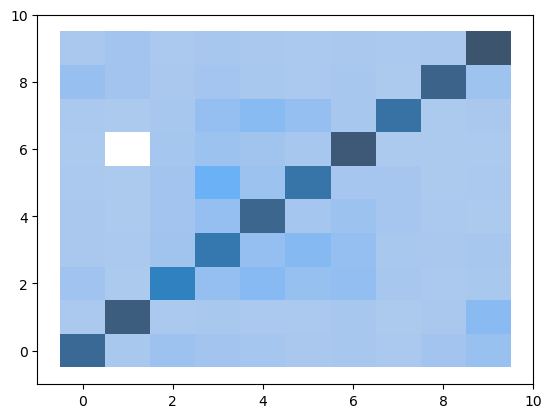

In [43]:
sns.histplot(x=predicted_labels,y=truth,discrete=True,bins=20)

----------------- 3560 -----------------
Predicted Probability 1.00 Class 9 Truck
True Class 1 Car
(3, 32, 32)


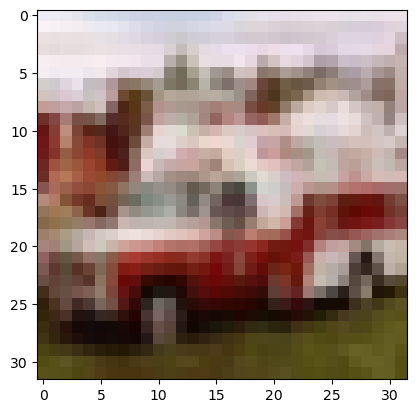

----------------- 2405 -----------------
Predicted Probability 1.00 Class 6 Frog
True Class 3 Cat
(3, 32, 32)


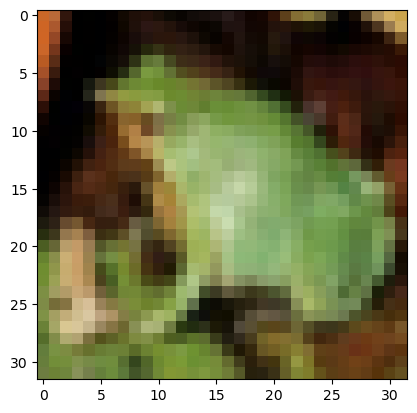

----------------- 1072 -----------------
Predicted Probability 1.00 Class 8 Ship
True Class 0 Plane
(3, 32, 32)


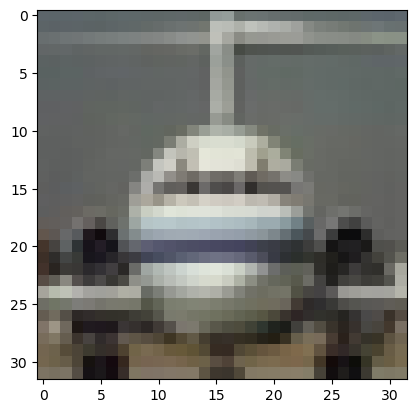

----------------- 7792 -----------------
Predicted Probability 1.00 Class 1 Car
True Class 9 Truck
(3, 32, 32)


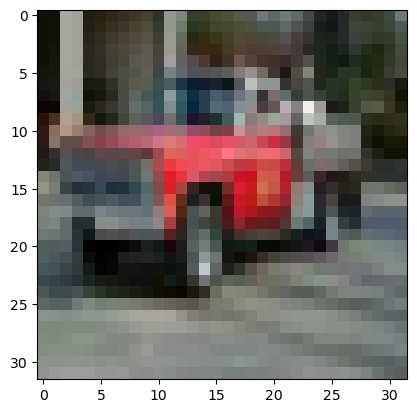

----------------- 2226 -----------------
Predicted Probability 1.00 Class 6 Frog
True Class 2 Bird
(3, 32, 32)


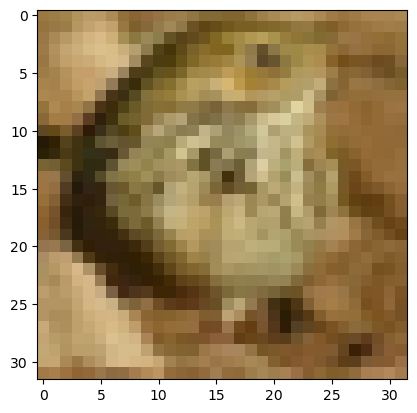

----------------- 7892 -----------------
Predicted Probability 1.00 Class 9 Truck
True Class 1 Car
(3, 32, 32)


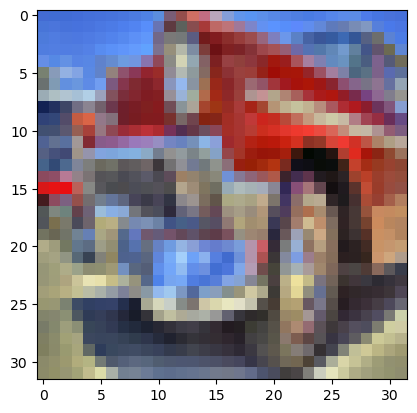

----------------- 3645 -----------------
Predicted Probability 1.00 Class 9 Truck
True Class 1 Car
(3, 32, 32)


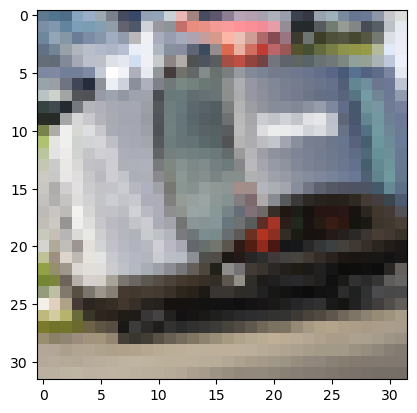

----------------- 6044 -----------------
Predicted Probability 1.00 Class 4 Deer
True Class 7 Horse
(3, 32, 32)


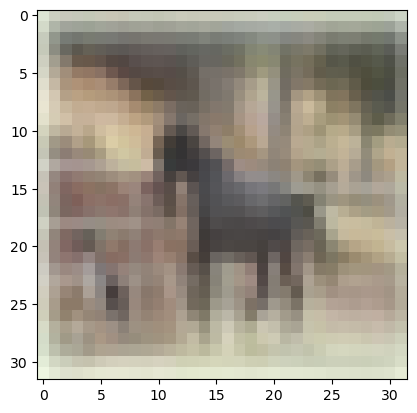

----------------- 926 -----------------
Predicted Probability 1.00 Class 6 Frog
True Class 8 Ship
(3, 32, 32)


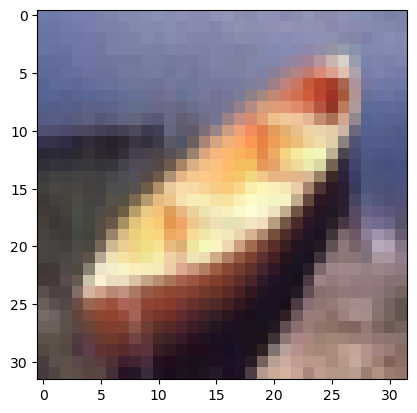

----------------- 9227 -----------------
Predicted Probability 1.00 Class 9 Truck
True Class 1 Car
(3, 32, 32)


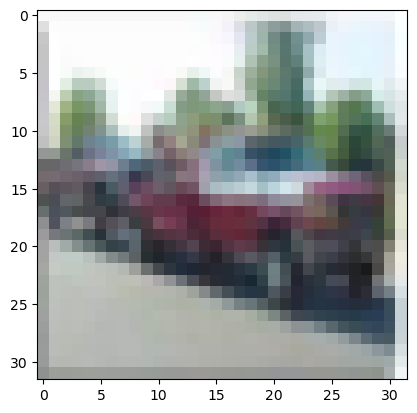

In [45]:
import matplotlib.pyplot as plt
wrong= (predicted_labels != truth)
sorted_prediction=np.flip(np.argsort(prediction.max(axis=1)))

worst_predictions= [i for i in sorted_prediction if wrong[i]]

for index in worst_predictions[0:10]:
    
    print("-----------------",index,"-----------------")
    print(f"Predicted Probability {prediction[index].max().item():.2f}", 'Class' ,predicted_labels[index], cifar_lookup_dict[predicted_labels[index]])
    print("True Class",truth[index], cifar_lookup_dict[truth[index]])
    _plot_img=imgs[index]
    print(_plot_img.shape)
    plt.imshow(((_plot_img.transpose((1,2,0))+1)/2*255).astype('uint8'))
    plt.show()
    

In [46]:
((_plot_img.transpose((1,2,0))+1)/2*255).astype('int')

array([[[248, 248, 248],
        [247, 247, 247],
        [248, 248, 248],
        ...,
        [243, 246, 250],
        [244, 247, 249],
        [253, 254, 255]],

       [[223, 223, 223],
        [252, 252, 252],
        [252, 252, 252],
        ...,
        [233, 243, 251],
        [234, 242, 248],
        [250, 255, 255]],

       [[199, 199, 199],
        [254, 254, 254],
        [253, 253, 253],
        ...,
        [228, 243, 253],
        [229, 240, 249],
        [247, 254, 255]],

       ...,

       [[154, 156, 155],
        [186, 188, 184],
        [184, 186, 181],
        ...,
        [139, 151, 156],
        [126, 139, 144],
        [214, 222, 223]],

       [[153, 155, 154],
        [182, 184, 181],
        [181, 183, 178],
        ...,
        [157, 166, 163],
        [159, 169, 170],
        [227, 233, 233]],

       [[143, 145, 144],
        [156, 158, 154],
        [155, 157, 152],
        ...,
        [142, 147, 141],
        [167, 174, 173],
        [240, 244, 244]]